In [1]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
config.update("jax_enable_x64", True)

# Set parameters.

In [2]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 4
t = 1.0
t_prime = 0.3
mu = 0.0

# Exact part

In [3]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

## Construct the reduced Hamiltonian.

In [4]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-5.657 -5.372 -4.374 -3.901 -3.901 -3.254 -1.716 -1.716]


In [5]:
U_sweep = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

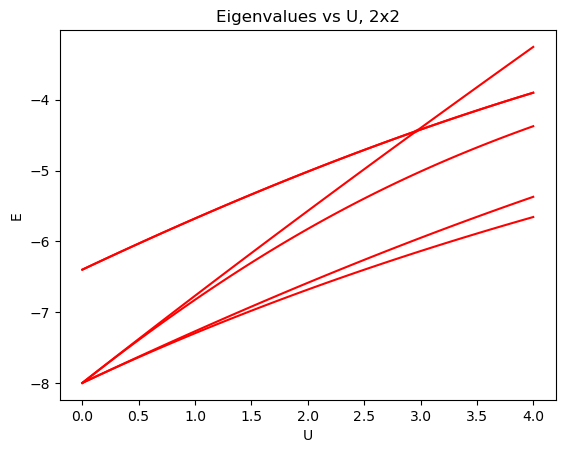

In [6]:
for band in range(6):
    plt.plot(U_sweep, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [7]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [8]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-8.  -8.  -8.  -8.  -6.4 -6.4 -6.4 -6.4]


In [9]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:1])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [4, 4, 1, 4, 10, 4, 1, 4, 4]
Number of degerate Eigenvalues:
 [4]
Eigenvalues of first Hi: 
 [0.75 0.75 1.25 1.25]


In [10]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [11]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [12]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

# Eigenbranches

In [13]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 5000
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [14]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

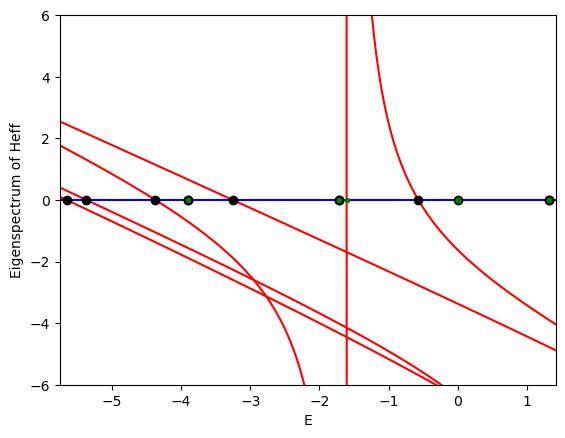

In [15]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-6, 6)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

# Binary search

In [43]:
U_sweep = jnp.linspace(0, U, 8)

In [17]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=1e-8, max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()

for i, UU in enumerate(U_sweep):
    print('i',i)
    # Skip the first iteration
    if i == 0:
        continue
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

i 0
i 1
Converged in 25 iterations.
-7.587476248843496
Converged in 25 iterations.
-7.577988812803248
Converged in 25 iterations.
-7.309325933423869
Converged in 26 iterations.
-7.291910559450182
i 2
Converged in 24 iterations.
-7.205019733395594
Converged in 25 iterations.
-7.169828336079506
Converged in 25 iterations.
-6.670938831067369
Converged in 25 iterations.
-6.595499190475996
i 3
Converged in 24 iterations.
-6.849839096091244
Converged in 24 iterations.
-6.776596889628465
Converged in 23 iterations.
-6.091380030437822
Converged in 25 iterations.
-5.909727293214303
i 4
Converged in 24 iterations.
-6.519470763992313
Converged in 24 iterations.
-6.399318196423641
Converged in 21 iterations.
-5.574255207042194
Converged in 25 iterations.
-5.23361286382132
i 5
Converged in 23 iterations.
-6.211750313360378
Converged in 24 iterations.
-6.038917713991971
Converged in 19 iterations.
-5.11900807022178
Converged in 25 iterations.
-4.566240854806233
i 6
Converged in 23 iterations.
-5.924

In [18]:
H_eigvals_sweep = []

for UU in U_sweep:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

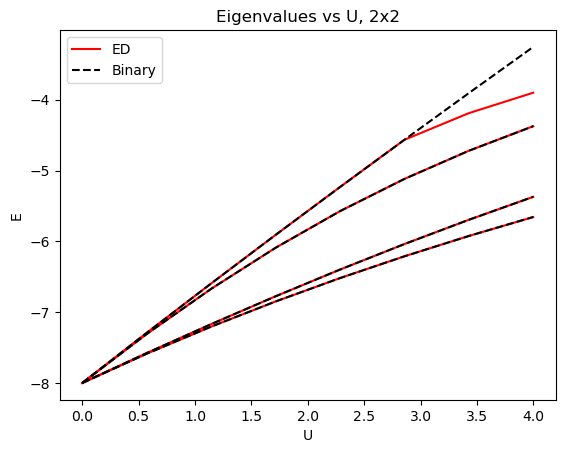

In [19]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [32]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

-7.416090852530033e-09
-5.8044147266400614e-09
-3.99192678912641e-09
-5.251361123725928e-09


error

In [44]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=1e-5, max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()

for i, UU in enumerate(U_sweep):
    print('i',i)
    # Skip the first iteration
    if i == 0:
        continue
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

i 0
i 1
Converged in 15 iterations.
-7.587482355114712
Converged in 15 iterations.
-7.5779951688455265
Converged in 15 iterations.
-7.309335568198095
Converged in 16 iterations.
-7.291915895165165
i 2
Converged in 15 iterations.
-7.205024952859117
Converged in 15 iterations.
-7.169834249380886
Converged in 15 iterations.
-6.670945319251267
Converged in 16 iterations.
-6.595504269142435
i 3
Converged in 14 iterations.
-6.84984781329964
Converged in 15 iterations.
-6.776602197147323
Converged in 14 iterations.
-6.091386734046107
Converged in 15 iterations.
-5.9097368808620665
i 4
Converged in 14 iterations.
-6.51947776943988
Converged in 14 iterations.
-6.399327501850687
Converged in 13 iterations.
-5.574260407453735
Converged in 15 iterations.
-5.233621775455765
i 5
Converged in 14 iterations.
-6.211755795883622
Converged in 14 iterations.
-6.038925470398562
Converged in 11 iterations.
-5.119015777039321
Converged in 15 iterations.
-4.566249060232847
i 6
Converged in 13 iterations.
-5.9

In [45]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

-6.731631942535898e-06
-4.6745892960942115e-06
-6.248804462316571e-06
-6.822102855963408e-06


In [34]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=1e-3, max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()

for i, UU in enumerate(U_sweep):
    print('i',i)
    # Skip the first iteration
    if i == 0:
        continue
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

i 0
i 1
Converged in 8 iterations.
-7.588268789748106
Converged in 8 iterations.
-7.578807502920331
Converged in 9 iterations.
-7.309964487910083
Converged in 9 iterations.
-7.29259744365053
i 2
Converged in 8 iterations.
-7.205723600594467
Converged in 8 iterations.
-7.170604666704933
Converged in 9 iterations.
-6.671424752988914
Converged in 9 iterations.
-6.596162946955612
i 3
Converged in 8 iterations.
-6.850449564626347
Converged in 8 iterations.
-6.777316076270093
Converged in 8 iterations.
-6.092018859261161
Converged in 9 iterations.
-5.910362517825598
i 4
Converged in 8 iterations.
-6.519990915058001
Converged in 8 iterations.
-6.3999685917271965
Converged in 7 iterations.
-5.57498966668057
Converged in 9 iterations.
-5.2342165703043495
i 5
Converged in 7 iterations.
-6.2126555120342974
Converged in 8 iterations.
-6.039490316636125
Converged in 6 iterations.
-5.119778341813952
Converged in 9 iterations.
-4.566811488551734
i 6
Converged in 7 iterations.
-5.92553444502038
Conver

In [35]:
H_eigvals_sweep = []

for UU in U_sweep:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

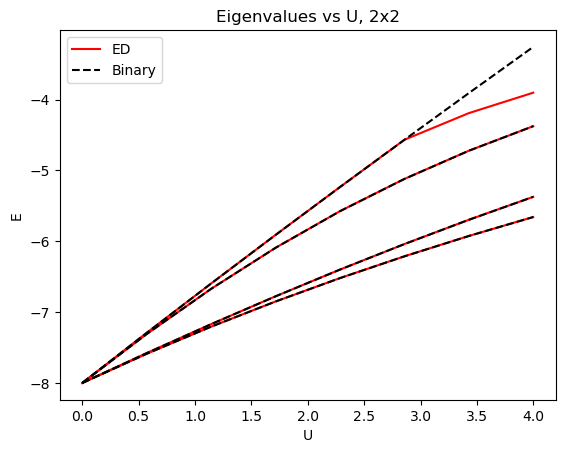

In [36]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [37]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

-0.0006328387015930304
-0.0008522981888496872
-0.00024742186599446825
-0.0005040287096056417


step

In [38]:
U_sweep = jnp.linspace(0, U, 80)

In [39]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=1e-8, max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()

for i, UU in enumerate(U_sweep):
    print('i',i)
    # Skip the first iteration
    if i == 0:
        continue
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

i 0
i 1
Converged in 21 iterations.
-7.9621551334006835
Converged in 21 iterations.
-7.962075524407716
Converged in 22 iterations.
-7.936885010383923
Converged in 22 iterations.
-7.936758813681601
i 2
Converged in 21 iterations.
-7.924568361437361
Converged in 21 iterations.
-7.924251945119655
Converged in 22 iterations.
-7.874125866765741
Converged in 22 iterations.
-7.873617004081275
i 3
Converged in 21 iterations.
-7.887237438821664
Converged in 21 iterations.
-7.886530033176754
Converged in 22 iterations.
-7.81172795128883
Converged in 22 iterations.
-7.810573819928113
i 4
Converged in 21 iterations.
-7.850160129908893
Converged in 21 iterations.
-7.848910551294287
Converged in 22 iterations.
-7.749696660619233
Converged in 22 iterations.
-7.747628503749793
i 5
Converged in 21 iterations.
-7.813334218141942
Converged in 21 iterations.
-7.8113942627657655
Converged in 22 iterations.
-7.688037406521342
Converged in 22 iterations.
-7.684780299566253
i 6
Converged in 21 iterations.
-7.

In [40]:
H_eigvals_sweep = []

for UU in U_sweep:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

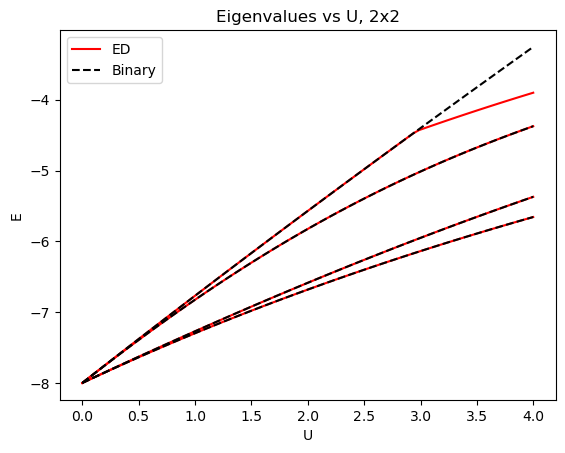

In [41]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [42]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 5])

-6.149647902020661e-09
-4.642598305792944e-09
-3.4952858385395302e-09
-8.128731021628255e-09
